In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn. model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.svm import SVR 

In [2]:
#these steps were done in eda
#dropping rows with fare amounts less than zero or equal 
#dropping rows with passenger count equal to zero
#dropping rows with distances more than 300 km from distinations
#dropping rows with distances driven more than 100 km
#dropping rows with a fare amount bigger than 100 and started in New York City

In [3]:
#loading dataset and dropping longtitude and latitude columns
trips = pd.read_csv(r"C:\Cellula\task 5\trips.csv")
trips.drop(columns= trips.columns[9:13], axis= 1, inplace= True)

In [4]:
#creating dummy variables for end distination
trips['to_jfk'] = (trips['jfk_dist'] <= 2).astype(int)
trips['to_ewr'] = (trips['ewr_dist'] <= 2).astype(int)
trips['to_lga'] = (trips['lga_dist'] <= 2).astype(int)
trips['to_sol'] = (trips['sol_dist'] <= 2).astype(int)
trips['to_nyc'] = (trips['nyc_dist'] <= 2).astype(int)

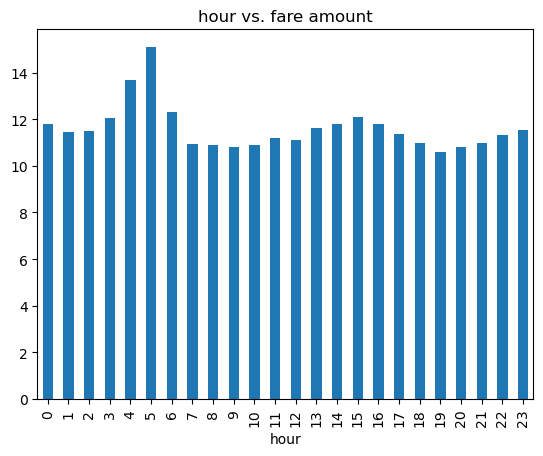

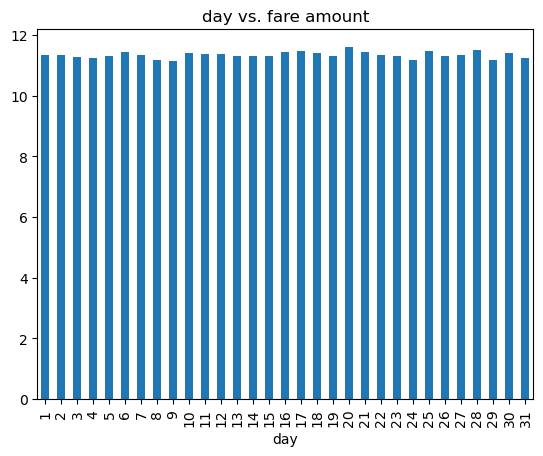

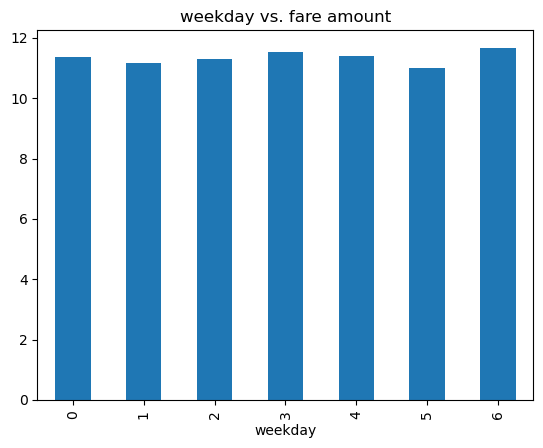

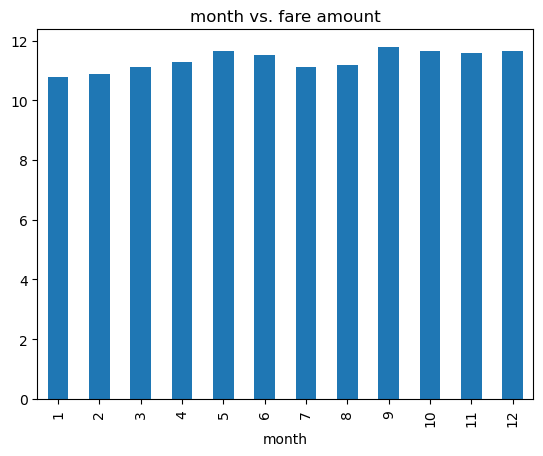

In [5]:
#these bar charts show that only hours affect fare amount so they will be one hot encoded
for feat in ['hour', 'day', 'weekday', 'month']:
    trips.groupby(feat)['fare_amount'].mean().plot(kind= 'bar', title= f'{feat} vs. fare amount')
    plt.show()

In [6]:
#creating dummy variables for signifigant hours
for hour in [4, 5, 9, 19]:
    trips[f'hour_{hour}'] = (trips['hour'] == hour).astype(int)

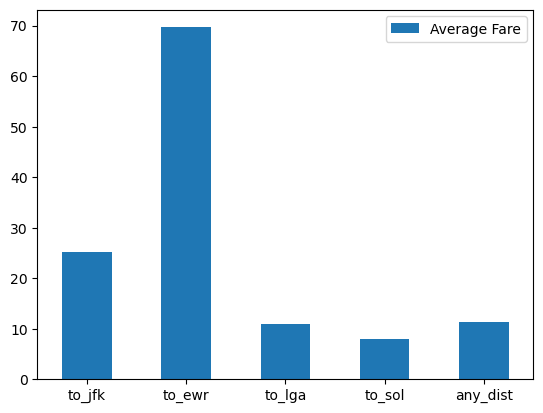

In [7]:
#bar chart to show that distination affects average fare
fare_means = {}
for dist in ['to_jfk', 'to_ewr', 'to_lga', 'to_sol']:
    fare_means[dist] = trips.loc[trips[dist] == 1, 'fare_amount'].mean()
fare_means['any_dist'] = trips['fare_amount'].mean()
fare_means_df = pd.DataFrame.from_dict(fare_means, orient='index', columns=['Average Fare'])
fare_means_df.plot(kind= 'bar', rot= 0)
plt.show()

In [8]:
#logging distances and fare amount since they have alot of outliers
trips[['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance', 'fare_amount']] = np.log(trips[['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance', 'fare_amount']].replace(0, 1))


In [9]:
#dropping costing features
trips.drop(['user_id', 'user_name', 'driver_name', 'key', 'pickup_datetime', 'year', 'hour', 'day', 'weekday', 'month'], axis= 1 ,inplace= True)


In [10]:
#one-hot encoding of categorical features
trips.rename(columns={'car_condition' : 'cc', 'weather' : 'w', 'traffic_condition' : 'tc'}, inplace= True)
onehotencoder = preprocessing.OneHotEncoder(sparse_output= False)
ohe = onehotencoder.fit_transform(trips[['cc', 'w', 'tc']])
ohe_df = pd.DataFrame(ohe, columns= onehotencoder.get_feature_names_out(['cc', 'w', 'tc']))
ohe_df.columns = [x.lower() for x in ohe_df.columns]
trips_encoded = pd.concat([trips, ohe_df], axis= 1)
trips_encoded.drop(['cc', 'w', 'tc'], axis= 1, inplace= True)


In [11]:
#normalizing non-encoded features
scaler = preprocessing.StandardScaler()
non_scaled_feat = ['jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist', 'distance', 'fare_amount', 'passenger_count']
scaled_data = scaler.fit_transform(trips_encoded[non_scaled_feat])
scaled_df = pd.DataFrame(scaled_data, columns= trips_encoded[non_scaled_feat].columns)
trips_encoded.drop(non_scaled_feat, axis= 1, inplace= True)
trips_scaled_encoded = pd.concat([trips_encoded, scaled_df], axis= 1)


In [12]:
#testing correlation with fare amount
trips_corr = trips_scaled_encoded.corr()
postive_corr = trips_corr['fare_amount'].loc[trips_corr['fare_amount'].between(0.1, 0.99)].index.tolist()
print('Positvely correlated:', postive_corr)
negative_corr = trips_corr['fare_amount'].loc[trips_corr['fare_amount'] < -0.1].index.tolist()
print('Negatively correlated:', negative_corr)
corr = postive_corr + negative_corr
corr


Positvely correlated: ['nyc_dist', 'distance']
Negatively correlated: []


['nyc_dist', 'distance']

In [13]:
#setting target variable
trips_target = trips['fare_amount']
trips_scaled_encoded.drop('fare_amount', axis= 1, inplace= True)


In [14]:
#multi collinearity analysis
reg_trips = trips_scaled_encoded[corr]
vif_data = pd.DataFrame()
vif_data['feature'] = corr
vif_data['vif'] = [variance_inflation_factor(reg_trips.values, i) for i in range(len(corr))]
vif_data


,feature,vif
0,nyc_dist,1.000004
1,distance,1.000004


In [15]:
#counting rows
trips_scaled_encoded.count()


bearing                 497030
start_out_nyc           497030
cancelled               497030
to_jfk                  497030
to_ewr                  497030
to_lga                  497030
to_sol                  497030
to_nyc                  497030
hour_4                  497030
hour_5                  497030
hour_9                  497030
hour_19                 497030
cc_bad                  497030
cc_excellent            497030
cc_good                 497030
cc_very good            497030
w_cloudy                497030
w_rainy                 497030
w_stormy                497030
w_sunny                 497030
w_windy                 497030
tc_congested traffic    497030
tc_dense traffic        497030
tc_flow traffic         497030
jfk_dist                497030
ewr_dist                497030
lga_dist                497030
sol_dist                497030
nyc_dist                497030
distance                497030
passenger_count         497030
dtype: int64

In [16]:
#k_folds
k_folds = KFold(n_splits= 5, shuffle= True, random_state= 36)


In [17]:
#random forest regressor
random_forest = RandomForestRegressor(n_estimators= 5, random_state= 32, n_jobs= -1)
scores = cross_val_score(random_forest, trips_scaled_encoded, trips_target, cv= k_folds)
print('Cross validation scores:', scores)
print('Average vross validation score:', round(scores.mean()*100, 2), '%')


Cross validation scores: [0.74488754 0.74538261 0.74914435 0.74801394 0.75199893]
Average vross validation score: 74.79 %


In [18]:
#linear regression
reg = LinearRegression(n_jobs= -1)
scores = cross_val_score(reg, reg_trips, trips_target, cv= k_folds)
print('Cross validation scores:', scores)
print('Average vross validation score:', round(scores.mean()*100, 2), '%')


Cross validation scores: [0.57000154 0.57858626 0.55700798 0.56331345 0.57640794]
Average vross validation score: 56.91 %


#######################


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data = pd.read_csv('final_internship_data.csv')  

data = data.drop(['User ID', 'User Name', 'Driver Name', 'key'], axis=1)

data = data.dropna()

categorical_cols = ['Car Condition', 'Weather', 'Traffic Condition']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_year'] = data['pickup_datetime'].dt.year

data = data.drop('pickup_datetime', axis=1)

X = data.drop('fare_amount', axis=1)
y = data['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}


results = {}
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse}, R2: {r2}")

best_model = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest Model: {best_model} with R2: {results[best_model]['R2']}")

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")